In [1]:
from owslib.wmts import WebMapTileService
import time
import math
import WMTS_General_Map as general
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os


## Experimental Testing for getting photo's out of multiple WMTS servers.
This Notebook experiments with a way  to get photo's as a datasource to later integrate it into the SailingRobots Website. 

The static variables like the website and the normal map layer.

In [2]:
config = general.get_config_from_json()
for wmts in config["wmts"]:
    if "ignore" not in wmts:
        try:
            wmts["tile_service"] = WebMapTileService(wmts["url"])
            time.sleep(0.01)
        except Exception as e:
            print(e, wmts["name"])
standardized_rendering_pixel_size = config["standardized_rendering_pixel_size"]


Get a single image information calculated by the coordinates given. This is so that we can later get images for multiple points and see which of these is at a certain water depth.

In [3]:
def split_fact_and_whole(value):
    part, whole = math.modf(value)
    part = round(part, 4)
    whole = int(whole)
    return whole, part


def get_single_height_width(matrix, lat, lon, convert):
    delta_width = matrix.tilewidth * standardized_rendering_pixel_size * matrix.scaledenominator
    delta_height = matrix.tileheight * standardized_rendering_pixel_size * matrix.scaledenominator
    if not convert:
        finn_coordinates = (lat, lon)
    else:
        finn_coordinates = general.convert_coordinate_systems(lat=lat, lon=lon, src=convert)
    calculated_width = (finn_coordinates[0] - matrix.topleftcorner[0]) / delta_width
    calculated_height = (matrix.topleftcorner[1] - finn_coordinates[1]) / delta_height
    width, width_part = split_fact_and_whole(calculated_width)
    height, height_part = split_fact_and_whole(calculated_height)
    width_in_image = matrix.tilewidth * width_part
    height_in_image = matrix.tileheight * height_part
    return height, width, height_in_image, width_in_image


If the tileset is not given it calculates the matrix and and set's the default level.

In [4]:
def get_column_row_for_coordinate_at_level_single(latitude, longitude, wmts, tile_matrix_set_name_, convert,
                                                  tileset=None, level=2):
    if tileset == None:
        tileset = wmts.tilematrixsets[tile_matrix_set_name_]
        list_of_tilematrixes = list(tileset.tilematrix.keys())
    matrix = tileset.tilematrix[list_of_tilematrixes[level]]
    codes = get_single_height_width(
        matrix,
        lat=latitude,
        lon=longitude,
        convert=convert)
    return codes


Sometimes the level has a special name and is not in this specific level. So then we change the name to the correct setting and perhaps go up a few level's. This makes sure that we get an image which contains the correct point

In [5]:
def get_level_if_special(level, specified_map_layer, tile_matrix_set_name_, wmts_):
    tile_level = '{0}:{1}'.format(tile_matrix_set_name_, level)
    tms = wmts_.contents[specified_map_layer]
    while tile_level not in tms.tilematrixsetlinks[tile_matrix_set_name_].tilematrixlimits:
        level -= 1
        tile_level = '{0}:{1}'.format(tile_matrix_set_name_, level)
    return level, tile_level


Sometimes to have a better resolution of the images the map is split up in the different filmatrixwidthes. This then has an extension of 0 to 9. To execute this function `split` has to be in the `config.json` file for this specific layer.  

In [6]:
def get_specified_map_layer_if_split_up(column, row, specified_map_layer, tile_level, tile_matrix_set_name_, wmts_):
    found = False
    i = -1
    while not found:
        i += 1
        tms = wmts_.contents[specified_map_layer + '{0}'.format(i)]
        limits = tms.tilematrixsetlinks[tile_matrix_set_name_].tilematrixlimits[tile_level]
        if limits.mintilerow <= row <= limits.maxtilerow and limits.mintilecol <= column <= limits.maxtilecol:
            found = True
        if i > 10:
            break
    return specified_map_layer + '{0}'.format(i)


This method executes the other methods and displays the image.

In [7]:
def get_image_for_coordinate(latitude, longitude, level, wmts_, tile_matrix_set_name_, specified_map_layer,
                             special_level, split_up, convert=False):
    tile_level = '{0}'.format(level)
    if special_level:
        level, tile_level = get_level_if_special(level, specified_map_layer, tile_matrix_set_name_, wmts_)
    codes = get_column_row_for_coordinate_at_level_single(latitude=latitude,
                                                          longitude=longitude,
                                                          wmts=wmts_,
                                                          level=level,
                                                          tile_matrix_set_name_=tile_matrix_set_name_,
                                                          convert=convert)
    row, column, pos_image_height, pos_image_width = codes
    if split_up:
        specified_map_layer = get_specified_map_layer_if_split_up(column, row, specified_map_layer, tile_level,
                                                                  tile_matrix_set_name_, wmts_)

    tile = wmts_.gettile(layer=specified_map_layer,
                         tilematrixset=tile_matrix_set_name_,
                         tilematrix='{0}'.format(tile_level),
                         row=row,
                         column=column,
                         format=wmts_.contents[specified_map_layer].formats[-1])
    time.sleep(0.1)
    return tile.read(), pos_image_height, pos_image_width


In [8]:
def plot_image(img, pos_image_height, pos_image_width):
    fw = open('image.jpeg', 'wb')
    fw.write(img)
    fw.close()
    img = mpimg.imread('image.jpeg', format='jpeg')
    plt.figure()
    plt.imshow(img)
    plt.plot(pos_image_width, pos_image_height, color='yellow', marker='+')
    plt.show()
    os.remove('image.jpeg')


The execution of getting a certain images from the coordinates file. it also has an infrared option at maasto

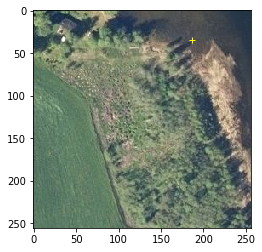

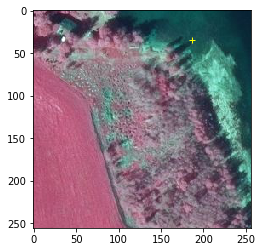

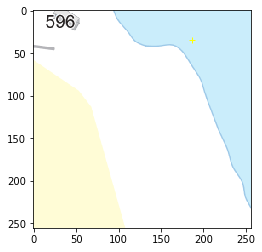

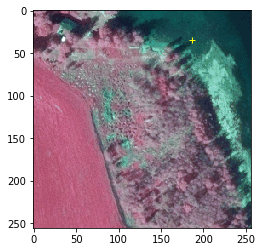

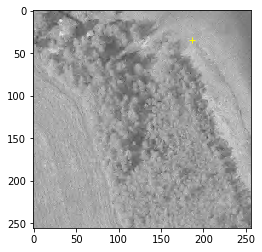

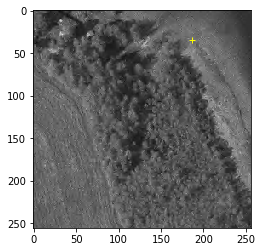

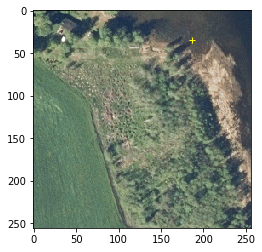

In [9]:
info_dict = general.get_coordinates_from_file()[1]
for wmts in config["wmts"]:
    if "ignore" not in wmts:
        for layer in wmts["map_layers"]:
            img, pos_image_height, pos_image_width = get_image_for_coordinate(
                info_dict['latitude'],
                info_dict['longitude'],
                info_dict['level'],
                wmts_=wmts["tile_service"],
                tile_matrix_set_name_=wmts["set_name"],
                specified_map_layer=layer["layer"],
                special_level='special_level' in wmts,
                split_up='split' in layer,
                convert=info_dict['type']
            )
            plot_image(img, pos_image_height, pos_image_width)
